In [1]:
import tensorflow as tf
import xgboost as xgb
import pandas as pd
import functools
import time
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, \
    auc, average_precision_score, pairwise_distances
import scikitplot as skplt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgb_hyper import objective
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import pickle
import dill
from functools import partial

C:\Users\tomas\miniconda3\envs\binding\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tomas\miniconda3\envs\binding\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tomas\miniconda3\envs\binding\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tomas\miniconda3\envs\binding\lib\site-packages\tensorf

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
print("The following GPU devices ara available: %s"%tf.test.gpu_device_name())

The following GPU devices ara available: /device:GPU:0


In [3]:
def calculate_metrics(y_true, y_pred, plots=False):
    assert isinstance(y_true, np.ndarray), 'y_true should be np.array'
    assert len(y_true.shape) == len(y_pred.shape) == 1, 'y_true or y_pred shapes are not 1 (probably not squeezed)'
    y_pred_bin = y_pred > 0.5

    cf = confusion_matrix(y_true, y_pred_bin)
    tn, fp, fn, tp = cf.ravel()

    metrics = {
        'roc_auc': roc_auc_score(y_true, y_pred),
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'map': average_precision_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred_bin),
        'recall': recall_score(y_true, y_pred_bin),
        'accuracy': accuracy_score(y_true, y_pred_bin),
    }

    if plots:
        print('predictions histogram')
        plt.figure()
        plt.hist(y_pred, bins=int(len(y_pred) / 3))
        plt.show()

        print('confusion matrix')
        plt.figure()
        group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        group_counts = ['{0:0.0f}'.format(value) for value in
                        cf.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in
                             cf.flatten() / np.sum(cf)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
                  zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2, 2)
        sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
        plt.show()

        print('roc curve')
        random_probs = [0 for _ in range(len(y_true))]
        auc = roc_auc_score(y_true, y_pred)
        print('Logistic: ROC AUC=%.3f' % (auc))
        ns_fpr, ns_tpr, _ = roc_curve(y_true, random_probs)
        lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='random')
        plt.plot(lr_fpr, lr_tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

    return metrics


In [4]:
target = 'p38'
base_path = f'C:/Users/tomas/Documents/GitHub/kinase_binding'

data_fpath = base_path+f'/data/{target}/data.csv'
df=pd.read_csv(data_fpath).set_index('biolab_index')

with open(base_path+f'/data/{target}/train_val_folds.pkl', "rb") as in_f:
    train_val_folds = dill.load(in_f)
with open(base_path+f'/data/{target}/train_test_folds.pkl', "rb") as in_f:
    train_test_folds = dill.load(in_f)

In [5]:
training_list = [df.loc[train_val_folds[0][0]],
                 df.loc[train_val_folds[1][0]],
                 df.loc[train_val_folds[2][0]],
                 df.loc[train_val_folds[3][0]],
                 df.loc[train_val_folds[4][0]],
                 df.loc[train_val_folds[5][0]],
                 df.loc[train_test_folds[0]]
                 ]
validation_list = [df.loc[train_val_folds[0][1]],
                   df.loc[train_val_folds[1][1]],
                   df.loc[train_val_folds[2][1]],
                   df.loc[train_val_folds[3][1]],
                   df.loc[train_val_folds[4][1]],
                   df.loc[train_val_folds[5][1]],
                   df.loc[train_test_folds[1]]
                   ]

In [6]:
# defining the space
fspace = {
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.1, 1), #+
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.1, 1), #+
    'gamma' : hp.uniform('gamma', 0.1, 1), #+
    'learning_rate' : hp.uniform('learning_rate', 0.1, 1),
    'max_delta_step' : hp.quniform('max_delta_step',1,10,1),
    'max_depth' : hp.quniform('max_depth',6, 12, 1),
    'min_child_weight' : hp.quniform('min_child_weight',10 ,500 ,5),
    'reg_alpha' : hp.uniform('reg_alpha',0.1,100),
    'reg_lambda' : hp.uniform('reg_lambda',0.1,100),
    'subsample' : hp.uniform('subsample',0.1,1.0),
    'max_bin' : hp.quniform('max_bin',16,256,16)
    # add sampling method,max bin,predicto,monotone_constraints,interaction_constraints,single_precision_histogram
}

In [7]:
fmin_objective = partial(objective, train_sets = training_list, val_sets = validation_list)

In [8]:
def run_trials():

    trials_step = 0  # how many additional trials to do after loading saved trials. 1 = save after iteration
    max_trials = 1  # initial max_trials. put something small to not have to wait

    
    try:  # try to load an already saved trials object, and increase the max
        trials = pickle.load(open("xgboost.hyperopt", "rb"))
        print("Found saved Trials! Loading...")
        max_trials = len(trials.trials) + trials_step
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
    except:  # create a new trials object and start searching
        trials = Trials()

    best = fmin(fn = fmin_objective, space = fspace, algo=tpe.suggest, max_evals=max_trials, trials=trials)

    print("Best:", best)
    
    # save the trials object
    with open("xgboost.hyperopt", "wb") as f:
        pickle.dump(trials, f)
    return(trials)

In [9]:
trials = run_trials()

Found saved Trials! Loading...
Rerunning from 510 trials to 510 (+0) trials
100%|████████████████████████████████████████████████████████████████████████| 510/510 [00:00<?, ?trial/s, best loss=?]
Best: {'colsample_bylevel': 0.5612301667238877, 'colsample_bytree': 0.788688363076523, 'gamma': 0.35376030016117566, 'learning_rate': 0.4023692255888918, 'max_bin': 16.0, 'max_delta_step': 3.0, 'max_depth': 8.0, 'min_child_weight': 70.0, 'reg_alpha': 0.15030685758880047, 'reg_lambda': 15.311721955443915, 'subsample': 0.8303923929525608}


In [10]:
best_loss = trials.trials[0]['result']['loss']
for i in range(1,len(trials.trials)):
    if (trials.trials[i]['result']['loss'] <=  best_loss):
        best_loss = trials.trials[i]['result']['loss']
        index = i

    
best_params = trials.trials[index]['misc']['vals']
hyper_params = {
        "colsample_bylevel" : best_params['colsample_bylevel'][0],
        "colsample_bytree" : best_params['colsample_bytree'][0],
        "gamma" : best_params['gamma'][0],
        "eta" : best_params['learning_rate'][0],
        "max_delta_step" : int(best_params['max_delta_step'][0]),
        "max_depth" : int(best_params['max_depth'][0]),
        "min_child_weight" : int(best_params['min_child_weight'][0]),
        "alpha" : best_params['reg_alpha'][0],
        "lambda" : best_params['reg_lambda'][0],
        "subsample" : best_params['subsample'][0],
        "eval_metric":'auc',
        "objective":'binary:logistic',
        "booster":'gbtree',
        "tree_method" : 'gpu_hist',
        "single_precision_histogram" : True
}

In [24]:
hyper_params

{'colsample_bylevel': 0.5612301667238877,
 'colsample_bytree': 0.788688363076523,
 'gamma': 0.35376030016117566,
 'eta': 0.4023692255888918,
 'max_delta_step': 3,
 'max_depth': 8,
 'min_child_weight': 70,
 'alpha': 0.15030685758880047,
 'lambda': 15.311721955443915,
 'subsample': 0.8303923929525608,
 'eval_metric': 'auc',
 'objective': 'binary:logistic',
 'booster': 'gbtree',
 'tree_method': 'gpu_hist',
 'single_precision_histogram': True,
 'validate_parameters': 1}

In [11]:
from xgb_hyper import XGB_hyper
class_xgb = XGB_hyper(hyper_params)
training_metrics = {}
validation_metrics = {}
for i in range(len(training_list)):
    dmatrix_train,train_labels = class_xgb.to_xgb_input(training_list[i])
    dmatrix_val,val_labels = class_xgb.to_xgb_input(validation_list[i])
    evalist = [(dmatrix_val,'eval'),(dmatrix_train,'train')]
    assert len(validation_list[i].index.intersection(training_list[i].index)) == 0
    model = class_xgb.build_model(dmatrix_train,evalist,True,300)
    
    y_pred_val = model.predict(dmatrix_val)
    y_pred_train = model.predict(dmatrix_train)
    if i < 6:
        validation_metrics['Val_%s'%i] = calculate_metrics(np.array(val_labels),y_pred_val)
        training_metrics['Train_%s'%i] = calculate_metrics(np.array(train_labels),y_pred_train)
    elif i == 6:
        validation_metrics['Test'] = calculate_metrics(np.array(val_labels),y_pred_val)
        training_metrics['Test'] = calculate_metrics(np.array(train_labels),y_pred_train)
    
    
  


[0]	eval-auc:0.59833	train-auc:0.69090
[1]	eval-auc:0.60806	train-auc:0.71995
[2]	eval-auc:0.64928	train-auc:0.73635
[3]	eval-auc:0.67960	train-auc:0.75176
[4]	eval-auc:0.71301	train-auc:0.78339
[5]	eval-auc:0.72442	train-auc:0.78787
[6]	eval-auc:0.74803	train-auc:0.79680
[7]	eval-auc:0.76399	train-auc:0.80153
[8]	eval-auc:0.77175	train-auc:0.81010
[9]	eval-auc:0.77173	train-auc:0.81589
[10]	eval-auc:0.79036	train-auc:0.82503
[11]	eval-auc:0.79318	train-auc:0.82812
[12]	eval-auc:0.79397	train-auc:0.83235
[13]	eval-auc:0.80230	train-auc:0.83895
[14]	eval-auc:0.80247	train-auc:0.84107
[15]	eval-auc:0.80492	train-auc:0.84574
[16]	eval-auc:0.81062	train-auc:0.84825
[17]	eval-auc:0.81315	train-auc:0.85191
[18]	eval-auc:0.81539	train-auc:0.85357
[19]	eval-auc:0.82410	train-auc:0.85749
[20]	eval-auc:0.82768	train-auc:0.85918
[21]	eval-auc:0.83159	train-auc:0.86178
[22]	eval-auc:0.83174	train-auc:0.86249
[23]	eval-auc:0.83104	train-auc:0.86216
[24]	eval-auc:0.83335	train-auc:0.86460
[25]	eval-

[203]	eval-auc:0.86125	train-auc:0.92952
[204]	eval-auc:0.86023	train-auc:0.92980
[205]	eval-auc:0.86044	train-auc:0.92987
[206]	eval-auc:0.86009	train-auc:0.92994
[207]	eval-auc:0.85962	train-auc:0.92995
[208]	eval-auc:0.85920	train-auc:0.92973
[209]	eval-auc:0.85945	train-auc:0.93006
[210]	eval-auc:0.85951	train-auc:0.93003
[211]	eval-auc:0.86043	train-auc:0.93017
[212]	eval-auc:0.86097	train-auc:0.93025
[213]	eval-auc:0.86201	train-auc:0.93033
[214]	eval-auc:0.86252	train-auc:0.93062
[215]	eval-auc:0.86265	train-auc:0.93111
[216]	eval-auc:0.86287	train-auc:0.93113
[217]	eval-auc:0.86290	train-auc:0.93104
[218]	eval-auc:0.86333	train-auc:0.93115
[219]	eval-auc:0.86394	train-auc:0.93120
[220]	eval-auc:0.86366	train-auc:0.93138
[221]	eval-auc:0.86372	train-auc:0.93166
[222]	eval-auc:0.86271	train-auc:0.93192
[223]	eval-auc:0.86294	train-auc:0.93234
[224]	eval-auc:0.86249	train-auc:0.93247
[225]	eval-auc:0.86267	train-auc:0.93260
[226]	eval-auc:0.86243	train-auc:0.93268
[227]	eval-auc:0

[106]	eval-auc:0.87422	train-auc:0.90908
[107]	eval-auc:0.87492	train-auc:0.90925
[108]	eval-auc:0.87535	train-auc:0.90966
[109]	eval-auc:0.87753	train-auc:0.91062
[110]	eval-auc:0.87720	train-auc:0.91075
[111]	eval-auc:0.87726	train-auc:0.91141
[112]	eval-auc:0.87761	train-auc:0.91170
[113]	eval-auc:0.87859	train-auc:0.91250
[114]	eval-auc:0.87932	train-auc:0.91246
[115]	eval-auc:0.87865	train-auc:0.91242
[116]	eval-auc:0.88010	train-auc:0.91290
[117]	eval-auc:0.88146	train-auc:0.91346
[118]	eval-auc:0.88141	train-auc:0.91385
[119]	eval-auc:0.88082	train-auc:0.91371
[120]	eval-auc:0.88082	train-auc:0.91393
[121]	eval-auc:0.87927	train-auc:0.91394
[122]	eval-auc:0.88041	train-auc:0.91417
[123]	eval-auc:0.88041	train-auc:0.91439
[124]	eval-auc:0.88114	train-auc:0.91463
[125]	eval-auc:0.88132	train-auc:0.91470
[126]	eval-auc:0.88214	train-auc:0.91531
[127]	eval-auc:0.88292	train-auc:0.91533
[128]	eval-auc:0.88426	train-auc:0.91569
[129]	eval-auc:0.88326	train-auc:0.91591
[130]	eval-auc:0

[7]	eval-auc:0.76799	train-auc:0.81325
[8]	eval-auc:0.77524	train-auc:0.82018
[9]	eval-auc:0.77658	train-auc:0.82569
[10]	eval-auc:0.77951	train-auc:0.82930
[11]	eval-auc:0.78377	train-auc:0.83180
[12]	eval-auc:0.77900	train-auc:0.83427
[13]	eval-auc:0.78201	train-auc:0.83761
[14]	eval-auc:0.79298	train-auc:0.84285
[15]	eval-auc:0.79173	train-auc:0.84364
[16]	eval-auc:0.79257	train-auc:0.84706
[17]	eval-auc:0.79405	train-auc:0.85154
[18]	eval-auc:0.79836	train-auc:0.85390
[19]	eval-auc:0.79815	train-auc:0.85818
[20]	eval-auc:0.79334	train-auc:0.85939
[21]	eval-auc:0.79651	train-auc:0.86183
[22]	eval-auc:0.79349	train-auc:0.86217
[23]	eval-auc:0.79693	train-auc:0.86455
[24]	eval-auc:0.79922	train-auc:0.86630
[25]	eval-auc:0.80256	train-auc:0.86692
[26]	eval-auc:0.80173	train-auc:0.86866
[27]	eval-auc:0.80165	train-auc:0.87017
[28]	eval-auc:0.80333	train-auc:0.87067
[29]	eval-auc:0.80721	train-auc:0.87243
[30]	eval-auc:0.80529	train-auc:0.87340
[31]	eval-auc:0.80833	train-auc:0.87442
[32

[210]	eval-auc:0.85711	train-auc:0.93000
[211]	eval-auc:0.85752	train-auc:0.92993
[212]	eval-auc:0.85757	train-auc:0.92993
[213]	eval-auc:0.85689	train-auc:0.92992
[214]	eval-auc:0.85678	train-auc:0.92995
[215]	eval-auc:0.85661	train-auc:0.93000
[216]	eval-auc:0.85707	train-auc:0.93040
[217]	eval-auc:0.85757	train-auc:0.93044
[218]	eval-auc:0.85840	train-auc:0.93064
[219]	eval-auc:0.85803	train-auc:0.93065
[220]	eval-auc:0.85785	train-auc:0.93059
[221]	eval-auc:0.85697	train-auc:0.93084
[222]	eval-auc:0.85680	train-auc:0.93088
[223]	eval-auc:0.85698	train-auc:0.93101
[224]	eval-auc:0.85779	train-auc:0.93101
[225]	eval-auc:0.85762	train-auc:0.93121
[226]	eval-auc:0.85678	train-auc:0.93115
[227]	eval-auc:0.85618	train-auc:0.93120
[228]	eval-auc:0.85523	train-auc:0.93118
[229]	eval-auc:0.85476	train-auc:0.93112
[230]	eval-auc:0.85488	train-auc:0.93133
[231]	eval-auc:0.85591	train-auc:0.93174
[232]	eval-auc:0.85723	train-auc:0.93196
[233]	eval-auc:0.85709	train-auc:0.93195
[234]	eval-auc:0

[113]	eval-auc:0.85449	train-auc:0.91449
[114]	eval-auc:0.85520	train-auc:0.91461
[115]	eval-auc:0.85546	train-auc:0.91498
[116]	eval-auc:0.85477	train-auc:0.91505
[117]	eval-auc:0.85515	train-auc:0.91509
[118]	eval-auc:0.85526	train-auc:0.91518
[119]	eval-auc:0.85520	train-auc:0.91582
[120]	eval-auc:0.85528	train-auc:0.91587
[121]	eval-auc:0.85507	train-auc:0.91613
[122]	eval-auc:0.85566	train-auc:0.91658
[123]	eval-auc:0.85620	train-auc:0.91671
[124]	eval-auc:0.85612	train-auc:0.91688
[125]	eval-auc:0.85606	train-auc:0.91702
[126]	eval-auc:0.85629	train-auc:0.91738
[127]	eval-auc:0.85658	train-auc:0.91730
[128]	eval-auc:0.85688	train-auc:0.91735
[129]	eval-auc:0.85720	train-auc:0.91781
[130]	eval-auc:0.85689	train-auc:0.91800
[131]	eval-auc:0.85716	train-auc:0.91812
[132]	eval-auc:0.85802	train-auc:0.91848
[133]	eval-auc:0.85748	train-auc:0.91884
[134]	eval-auc:0.85736	train-auc:0.91877
[135]	eval-auc:0.85754	train-auc:0.91905
[136]	eval-auc:0.85719	train-auc:0.91913
[137]	eval-auc:0

[14]	eval-auc:0.80050	train-auc:0.84276
[15]	eval-auc:0.80473	train-auc:0.84487
[16]	eval-auc:0.81154	train-auc:0.84940
[17]	eval-auc:0.81865	train-auc:0.85225
[18]	eval-auc:0.81879	train-auc:0.85362
[19]	eval-auc:0.81855	train-auc:0.85338
[20]	eval-auc:0.82192	train-auc:0.85655
[21]	eval-auc:0.82459	train-auc:0.85761
[22]	eval-auc:0.82216	train-auc:0.85920
[23]	eval-auc:0.82406	train-auc:0.86205
[24]	eval-auc:0.81993	train-auc:0.86200
[25]	eval-auc:0.81955	train-auc:0.86285
[26]	eval-auc:0.82176	train-auc:0.86508
[27]	eval-auc:0.82621	train-auc:0.86656
[28]	eval-auc:0.82722	train-auc:0.86797
[29]	eval-auc:0.83072	train-auc:0.86943
[30]	eval-auc:0.83212	train-auc:0.87169
[31]	eval-auc:0.83338	train-auc:0.87290
[32]	eval-auc:0.83661	train-auc:0.87410
[33]	eval-auc:0.83460	train-auc:0.87506
[34]	eval-auc:0.83237	train-auc:0.87534
[35]	eval-auc:0.83365	train-auc:0.87626
[36]	eval-auc:0.83307	train-auc:0.87771
[37]	eval-auc:0.83332	train-auc:0.87825
[38]	eval-auc:0.83297	train-auc:0.87820


[216]	eval-auc:0.88113	train-auc:0.92839
[217]	eval-auc:0.88076	train-auc:0.92889
[218]	eval-auc:0.88079	train-auc:0.92893
[219]	eval-auc:0.88140	train-auc:0.92899
[220]	eval-auc:0.88060	train-auc:0.92939
[221]	eval-auc:0.88099	train-auc:0.92929
[222]	eval-auc:0.88168	train-auc:0.92941
[223]	eval-auc:0.88160	train-auc:0.92946
[224]	eval-auc:0.88140	train-auc:0.92951
[225]	eval-auc:0.88121	train-auc:0.92970
[226]	eval-auc:0.88274	train-auc:0.92994
[227]	eval-auc:0.88280	train-auc:0.92999
[228]	eval-auc:0.88290	train-auc:0.93002
[229]	eval-auc:0.88257	train-auc:0.93005
[230]	eval-auc:0.88266	train-auc:0.93008
[231]	eval-auc:0.88293	train-auc:0.92999
[232]	eval-auc:0.88290	train-auc:0.93019
[233]	eval-auc:0.88307	train-auc:0.93024
[234]	eval-auc:0.88440	train-auc:0.93015
[235]	eval-auc:0.88411	train-auc:0.93009
[236]	eval-auc:0.88460	train-auc:0.93022
[237]	eval-auc:0.88427	train-auc:0.93031
[238]	eval-auc:0.88429	train-auc:0.93044
[239]	eval-auc:0.88433	train-auc:0.93062
[240]	eval-auc:0

[119]	eval-auc:0.81590	train-auc:0.91056
[120]	eval-auc:0.81518	train-auc:0.91078
[121]	eval-auc:0.81702	train-auc:0.91125
[122]	eval-auc:0.81936	train-auc:0.91180
[123]	eval-auc:0.81945	train-auc:0.91197
[124]	eval-auc:0.82278	train-auc:0.91232
[125]	eval-auc:0.82184	train-auc:0.91249
[126]	eval-auc:0.82165	train-auc:0.91274
[127]	eval-auc:0.82355	train-auc:0.91312
[128]	eval-auc:0.82408	train-auc:0.91324
[129]	eval-auc:0.82164	train-auc:0.91362
[130]	eval-auc:0.82168	train-auc:0.91372
[131]	eval-auc:0.82039	train-auc:0.91363
[132]	eval-auc:0.82057	train-auc:0.91410
[133]	eval-auc:0.82072	train-auc:0.91441
[134]	eval-auc:0.82288	train-auc:0.91439
[135]	eval-auc:0.82482	train-auc:0.91434
[136]	eval-auc:0.82341	train-auc:0.91451
[137]	eval-auc:0.82360	train-auc:0.91460
[138]	eval-auc:0.82347	train-auc:0.91471
[139]	eval-auc:0.82255	train-auc:0.91442
[140]	eval-auc:0.82507	train-auc:0.91479
[141]	eval-auc:0.82605	train-auc:0.91499
[142]	eval-auc:0.82500	train-auc:0.91525
[143]	eval-auc:0

[20]	eval-auc:0.70148	train-auc:0.86308
[21]	eval-auc:0.70081	train-auc:0.86543
[22]	eval-auc:0.70571	train-auc:0.86608
[23]	eval-auc:0.70664	train-auc:0.86867
[24]	eval-auc:0.70173	train-auc:0.87005
[25]	eval-auc:0.69629	train-auc:0.87128
[26]	eval-auc:0.70620	train-auc:0.87272
[27]	eval-auc:0.71030	train-auc:0.87447
[28]	eval-auc:0.71086	train-auc:0.87617
[29]	eval-auc:0.70650	train-auc:0.87665
[30]	eval-auc:0.70871	train-auc:0.87836
[31]	eval-auc:0.71474	train-auc:0.88082
[32]	eval-auc:0.71815	train-auc:0.88159
[33]	eval-auc:0.72000	train-auc:0.88273
[34]	eval-auc:0.72224	train-auc:0.88407
[35]	eval-auc:0.72244	train-auc:0.88575
[36]	eval-auc:0.72981	train-auc:0.88616
[37]	eval-auc:0.73171	train-auc:0.88691
[38]	eval-auc:0.72935	train-auc:0.88762
[39]	eval-auc:0.72698	train-auc:0.88783
[40]	eval-auc:0.72937	train-auc:0.88958
[41]	eval-auc:0.73299	train-auc:0.89006
[42]	eval-auc:0.73748	train-auc:0.89134
[43]	eval-auc:0.74140	train-auc:0.89152
[44]	eval-auc:0.74050	train-auc:0.89156


[222]	eval-auc:0.76635	train-auc:0.93421
[223]	eval-auc:0.76680	train-auc:0.93433
[224]	eval-auc:0.76635	train-auc:0.93473
[225]	eval-auc:0.76748	train-auc:0.93473
[226]	eval-auc:0.76698	train-auc:0.93470
[227]	eval-auc:0.76759	train-auc:0.93508
[228]	eval-auc:0.76772	train-auc:0.93532
[229]	eval-auc:0.76755	train-auc:0.93555
[230]	eval-auc:0.76670	train-auc:0.93566
[231]	eval-auc:0.76689	train-auc:0.93563
[232]	eval-auc:0.76662	train-auc:0.93559
[233]	eval-auc:0.76805	train-auc:0.93554
[234]	eval-auc:0.76911	train-auc:0.93575
[235]	eval-auc:0.76969	train-auc:0.93574
[236]	eval-auc:0.76985	train-auc:0.93575
[237]	eval-auc:0.77009	train-auc:0.93596
[238]	eval-auc:0.76987	train-auc:0.93600
[239]	eval-auc:0.76975	train-auc:0.93609
[240]	eval-auc:0.77206	train-auc:0.93619
[241]	eval-auc:0.77204	train-auc:0.93611
[242]	eval-auc:0.77186	train-auc:0.93618
[243]	eval-auc:0.77140	train-auc:0.93655
[244]	eval-auc:0.77239	train-auc:0.93656
[245]	eval-auc:0.77218	train-auc:0.93658
[246]	eval-auc:0

In [13]:
pd.DataFrame(training_metrics).T

,roc_auc,tn,fp,fn,tp,map,precision,recall,accuracy
Train_0,0.906058,805.0,111.0,143.0,469.0,0.874231,0.808621,0.766340,0.833770
Train_1,0.903288,731.0,124.0,142.0,531.0,0.879504,0.810687,0.789004,0.825916
Train_2,0.911772,771.0,107.0,138.0,512.0,0.893155,0.827141,0.787692,0.839660
Train_3,0.915426,793.0,106.0,139.0,490.0,0.893372,0.822148,0.779014,0.839660
Train_4,0.906424,801.0,105.0,144.0,478.0,0.881838,0.819897,0.768489,0.837042
Train_5,0.907642,786.0,100.0,152.0,492.0,0.886869,0.831081,0.763975,0.835294
Test,0.919777,945.0,123.0,153.0,613.0,0.900827,0.832880,0.800261,0.849509


In [14]:
pd.DataFrame(validation_metrics).T

,roc_auc,tn,fp,fn,tp,map,precision,recall,accuracy
Val_0,0.852999,126.0,26.0,45.0,109.0,0.865227,0.807407,0.707792,0.767974
Val_1,0.897572,188.0,25.0,23.0,70.0,0.836908,0.736842,0.752688,0.843137
Val_2,0.859460,166.0,24.0,35.0,81.0,0.821637,0.771429,0.698276,0.807190
Val_3,0.812551,144.0,25.0,47.0,90.0,0.776678,0.782609,0.656934,0.764706
Val_4,0.861325,120.0,42.0,29.0,115.0,0.837536,0.732484,0.798611,0.767974
Val_5,0.850860,158.0,24.0,40.0,82.0,0.800765,0.773585,0.672131,0.789474
Test,0.872686,168.0,22.0,40.0,76.0,0.812078,0.775510,0.655172,0.797386


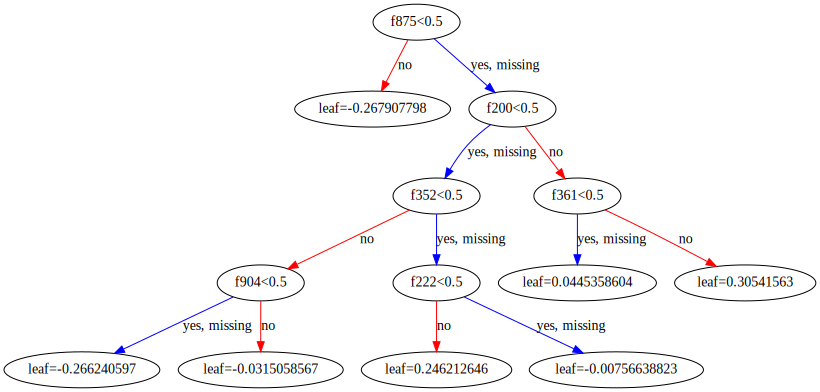

In [14]:
import graphviz
xgb.to_graphviz(model,num_trees= 1)